# 1. Requirments

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [2]:
#!pip install xgboost

import argparse

# general libraries
import pandas as pd
import numpy as np
# ML libraries 

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, linear_model, preprocessing
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC,SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve,accuracy_score,precision_score,roc_auc_score,confusion_matrix,classification_report,f1_score, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.utils import shuffle


# Image Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image

# feature engineering : Dimanssion reduction 
# 75*75 = 5,625 We are using PCA to reduce the number of features to 150
from sklearn.decomposition import PCA
# Jupyter Wedgets
from ipyfilechooser import FileChooser
# Plot libraries
from matplotlib import pyplot as plt
# Reporting libraries:
import pickle


Using TensorFlow backend.


# 2. Data Prepration Functions

In [4]:

def isqrt(n):#function to reshape the flaten image
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x
def image_plot(NP_array): # to plot te image 
    NP_array=np.array(NP_array)#convert to numpy array
    tem=NP_array.shape
    
    if len(tem)==1:
        x=isqrt(len(NP_array)) 
        NP_array=NP_array.reshape(x,x)  
    elif len(tem)>2:
        NP_array=NP_array.flatten()
        x=isqrt(len(NP_array)) 
        NP_array=NP_array.reshape(x,x)
        print("Please send 2D or 1D array")
    plt.imshow(NP_array)
    plt.show()    
def read_image(IMAGE,PLOT=0): 
    
    #img = load_img(IMAGE, target_size=(128, 128,)).convert('L') # if wanted to have 2D image in grayscale run this line
    img = load_img(IMAGE, target_size=(64, 64,3))

    img = np.array(img)
    img=img/255
    # plot the image
    if PLOT ==1:
        image_plot(img)
    
    flattened = img.flatten()
    #return img
    return flattened

def Dataset_prepration(path,csv_file,IMAGE="train/images/"): # read data from label and created a Dataset including flat and optimized Features
    df=pd.read_csv(path+csv_file)
    col=df.columns.tolist()
    col=[x for x in df.columns.tolist() if 'Unnamed: 0' not in x]
    df=df[col]
    #df["img"]=path+"train/images/"+df["img"]+".jpg"
    df["img"]=df.apply(lambda x : image_adjustment(x['img']),axis=1)
    
    df=df[df["label"]<3]# filtering the Cookies' images 
    Image_list=df["img"].tolist()
    data=[]
    for i in Image_list:
        data.append(read_image(i))
    data=PCA_reduction(data) # optimising the features using PCA
    return data,df
        
    
def image_adjustment(x):
    x=x.replace("img_","")
    x=path+"train/images/"+x+".jpg"
    return x
    
def PCA_reduction(data):
    pca = PCA(n_components=90, svd_solver='randomized', whiten=True)
    pca.fit(data)
    pickle.dump(pca, open('./pca.pkl','wb')) # PCA will modle will be saved for Production model
    components = pca.transform(data)
    return components
def model_reporting(report): # Analysis the report and sort the best CLF 
    Clfs=list(report.keys())
    DF_report=pd.DataFrame(columns=(["classifiers","Model_ACC","Model_validation_ACC","Optimized_ACC","Improvment"]))

    Data_report={}


    for i in range(0,len(Clfs)):
        DF_report.loc[i]=[Clfs[i],
                          report[Clfs[i]]["Original_model_Train_Acc"],
                          report[Clfs[i]]["Original_model_Test_Acc"],
                          report[Clfs[i]]["Optimized_model_Train_Acc"],
                          report[Clfs[i]]["Improvement"]
                         ]
    
    DF_report=DF_report.sort_values(by=['Model_ACC','Optimized_ACC'],ascending=False)
    DF_report.plot(x="classifiers",
                   y=['Model_ACC',
                      'Model_validation_ACC',
                      'Optimized_ACC'],
                   kind="bar",title="Model Accuracy Comparision") 
    return DF_report
    
    
    

# 3. Model Generation/Selection and Optimization

In [5]:
def modelling(x_train,y_train,x_test,y_test):
    model_dic={}
    #defining the models
    max_f=len(x_train[0])
    
    Logit=LogisticRegression()
    
    Logit_grid = {
         'penalty' : ['l2'],
        'C' : [0.012742749857031334],
        'solver' : ['liblinear']
        }
        
    Logit_grid = {
         'penalty' : ['l1', 'l2'],
        'C' : list(np.logspace(-4, 4, 20)),
        'solver' : ['liblinear']
        }

    SGD=SGDClassifier()
        
    SGD_grid = {
        
        "penalty": ["none", "l1", "l2"],
        "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'n_jobs': [-1]    
    }
    SGD_grid = {
        
        "penalty": ["l2"],
        "alpha": [0.01],
        'n_jobs': [-1]    
    }
    
    
    
    Gradian=GradientBoostingClassifier()
    Gradian_grid={
        'loss' : ['deviance', 'exponential'],
        "learning_rate":[0.10,0.15],
        "n_estimators":list(range(100,400,50)),
        "max_depth":list(range(0,10,3))
        }
    Gradian_grid={
        "learning_rate":[0.15],
        "n_estimators":[250],
        }


    XGB=XGBClassifier()
    XGB_grid={"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
              'n_jobs':[-1]} 
    XGB_grid={"learning_rate"    : [0.20 ] ,
     "max_depth"        : [ 10],
     "min_child_weight" : [3],
     "gamma"            : [ 0.1],
     "colsample_bytree" : [ 0.3]
              } 


    RF=RandomForestClassifier()
    RF_grid={
        'n_estimators' : list(range(100,500,50)),
        'max_features' : list(range(6,32,5)),
        'n_jobs':[-1],
        "criterion" : ["gini", "entropy"],
        "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
         "max_features" : ["auto", "sqrt", "log2"],
        "class_weight" : ["balanced", "balanced_subsample"],
        "ccp_alpha" : [0.0,0.005,0.01,0.05,0.1,0.15]}
    RF_grid={
        'n_estimators' : [100,300,500],

        "criterion" : ["gini"],
        "max_depth"        : [6,7,8],
         "max_features" : ["auto"],
        "class_weight" : ["balanced_subsample"],
        "ccp_alpha" : [0.1]}

    SVM=LinearSVC()
    SVM_grid={
    "penalty" : ['l1', 'l2'],
    "loss" : ['hinge', 'squared_hinge']
    }
    SVM_grid={
    "penalty" : ['l2'],
    "loss" : ['hinge']
    }


    KNN=KNeighborsClassifier()
    KNN_grid={
        'n_neighbors':list(range(10,100,10)),
        'weights' : ['uniform', 'distance'],
        'leaf_size':list(range(1,10,2)),
         'algorithm':['auto', 'kd_tree'],
         'n_jobs':[-1],
         "metric": ["euclidean", "cityblock"]}
    
    KNN_grid={
        'n_neighbors':[2,3,5],
        'weights' : ['distance'],
        'leaf_size':[1],
         'algorithm':['auto'],
         "metric": ["euclidean"]}
    


    Dtree=DecisionTreeClassifier()
    Dtree_grid= {'max_depth':list(range(1,12,2)), 
                  'min_samples_leaf':[1,2,3,4,5], 
                  'min_samples_split':[2,3,4,5],
                  'criterion' : ['gini','entropy'],
                 'min_weight_fraction_leaf' : [0.0,0.005,0.01,0.05,0.1,0.15],
                 "ccp_alpha" : [0.0,0.005,0.01,0.05,0.1,0.15]}
    
    Dtree_grid= {'max_depth':[6,7], 
                  'criterion' : ['gini'],
                 "ccp_alpha" : [0.1]}

    HistGB=HistGradientBoostingClassifier()
    HistGB_grid={
        'loss' : ['auto', 'binary_crossentropy', 'categorical_crossentropy'],
        "l2_regularization" : [0.0,0.005,0.01,0.05,0.1,0.15],
        "tol" : [1e-7,1e-6,1e-5,1e-4,1e-3]} 
    HistGB_grid={
        'loss' : ['binary_crossentropy', ],
        "l2_regularization" : [0.1,]} 
    
    Adaboost= AdaBoostClassifier()
    Adaboost_grid={
        "n_estimators":list(range(50,200,20)),
        'learning_rate':[0.001,0.05,0.10,0.15]
    }

    Adaboost_grid={
        "n_estimators":[70],
        'learning_rate':[0.10]
    }

    model_list=[Logit,SGD,Gradian,XGB,RF,SVM,KNN,Dtree,HistGB,Adaboost]# list of the models
    model_str=["Logistic_Regression","SGD Classifier",
               "Gradient BoostingClassifier",
              "XGB Classifier","Random_Forest_Classifier",
               "SVM","KNN","Decision_Tree","HistGradientBoostingClassifier","Adaboost"]#models names
    Optimized_list=[Logit_grid,SGD_grid,Gradian_grid,
                   XGB_grid,RF_grid,SVM_grid,KNN_grid,Dtree_grid,
                   HistGB_grid,Adaboost_grid]

    # run the model pipelines
    model_dic={}
    best_acc=0
    scorer = make_scorer(accuracy_score)
    for i in range(0,len(model_list)):
           
    
        model=model_list[i]
        model_name=model_str[i]
        model_dic[model_name]={}
        print("**************************************************")
        print(model_name ," is running .... ")
        print("**************************************************")
        model.fit(x_train, y_train) # train with selected Features

        y_pred = model.predict(x_test)# test the model performance using the selected features  
        #robY=model.predict_proba(X_test)#predict the probability for x
        trainscor= cross_val_score(model, x_train, y_train, cv=5)
        print("Accuracy of Train Dataset : %0.2f (+/- %0.2f)" % (trainscor.mean(), trainscor.std() * 2))
        # evaluate accuracy
        testscores=accuracy_score(y_test, y_pred)
        print ("Validation Model Accuracy Score:", accuracy_score(y_test, y_pred),testscores)
        model_dic[model_name]['Original_model_Train_Acc']=trainscor.mean()
        model_dic[model_name]['Original_model_Test_Acc']=testscores
        
        if testscores.mean() > best_acc:
            best_acc=testscores
            
            print("saving the model with Accuracy :",best_acc)
            pickle.dump(model, open('./model.pkl','wb'))
            
        
        
        #print(confusion_matrix(y_test, y_pred))
        CM=confusion_matrix(y_test, y_pred)
        print(CM)
        report=classification_report(y_test, y_pred)
        print('Model Performance')
        
        model_dic[model_name]['Original_model_CM']=[CM]
        model_dic[model_name]['Original_model_Report']=[report]
        #print("dict_level_1")
        print (report)
        
        
        
        """Optimized_model = RandomizedSearchCV(estimator = model,
                               param_distributions = Optimized_list[i],
                               n_iter = 100, cv = 5,
                               verbose=2, random_state=2, 
                               n_jobs = -1)"""
        
        """        
        Optimized_model = GridSearchCV(model_list[i],
                               Optimized_list[i],
                                cv = 5,
                               verbose=0, 
                                scoring=scorer )
                                """
        print("******* Optimization *******")
        Optimized_model = GridSearchCV(model_list[i],
                               Optimized_list[i],
                                cv = 5,
                               verbose=.5,
                                  n_jobs=3  )
        # Fit the random search model
        Optimized_model.fit(x_train, y_train)
        #get the best param:
        optimized_param=Optimized_model.best_params_
        print(optimized_param)
        model_dic[model_name]['Optimized_param']=optimized_param
        
        
        y_pred = Optimized_model.predict(x_test)# test the model performance using the selected features  
        #robY=model.predict_proba(X_test)#predict the probability for x
        trainscor= cross_val_score(Optimized_model, x_train, y_train, cv=5)
        print("Accuracy of Optimizaed_Train Dataset : %0.2f (+/- %0.2f)" % (trainscor.mean(), trainscor.std() * 2))
        # evaluate accuracy
        testscores  =accuracy_score(y_test, y_pred)
        print ("Validation Optimizaed_Model Accuracy Score:",testscores)
        #print(confusion_matrix(y_test, y_pred))
        CM=confusion_matrix(y_test, y_pred)
        print(CM)
        report=classification_report(y_test, y_pred)
        
        print('Optimized_Model Performance')
        print (report)
        print("****************************")
        #pickle.dump(model, open('./model/model.pkl','wb'))
        model_dic[model_name]['Optimized_model_Train_Acc']=trainscor.mean()
        model_dic[model_name]['Optimized_model_Test_Acc']=testscores
        model_dic[model_name]['Optimized_model_CM']=[CM]
        model_dic[model_name]['Optimized_model_Report']=[report]
        model_dic[model_name]['Improvement']=model_dic[model_name]['Optimized_model_Train_Acc']- model_dic[model_name]['Original_model_Train_Acc']
        if testscores.mean() > best_acc:
            best_acc=trainscor.mean()
            print("saving the optimized_model with Accuracy :",best_acc)
            pickle.dump(model, open('./model.pkl','wb'))
    DF_report=model_reporting(model_dic)
    return DF_report,model_dic 
        
        
        
        
        

# 4. Runin the Model

In [6]:
# dataset Prepration:
csv_file="label_train.csv"
path="./data/"
data,df=Dataset_prepration(path,csv_file)


**************************************************
Logistic_Regression  is running .... 
**************************************************
Accuracy of Train Dataset : 0.85 (+/- 0.03)
Validation Model Accuracy Score: 0.8766666666666667 0.8766666666666667
saving the model with Accuracy : 0.8766666666666667
[[139  20]
 [ 17 124]]
Model Performance
              precision    recall  f1-score   support

           1       0.89      0.87      0.88       159
           2       0.86      0.88      0.87       141

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300

******* Optimization *******
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 109 tasks      | elapsed:    6.8s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    8.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


{'C': 0.03359818286283781, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    1.7s finished


Accuracy of Optimizaed_Train Dataset : 0.85 (+/- 0.04)
Validation Optimizaed_Model Accuracy Score: 0.87
[[135  24]
 [ 15 126]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.90      0.85      0.87       159
           2       0.84      0.89      0.87       141

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300

****************************
**************************************************
SGD Classifier  is running .... 
**************************************************
Accuracy of Train Dataset : 0.81 (+/- 0.03)
Validation Model Accuracy Score: 0.83 0.83
[[131  28]
 [ 23 118]]
Model Performance
              precision    recall  f1-score   support

           1       0.85      0.82      0.84       159
           2       0.81      0.84      0.82       141

    accuracy                           0.83       300
   macro

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy of Optimizaed_Train Dataset : 0.85 (+/- 0.03)
Validation Optimizaed_Model Accuracy Score: 0.8666666666666667
[[134  25]
 [ 15 126]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.90      0.84      0.87       159
           2       0.83      0.89      0.86       141

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300

****************************
**************************************************
Gradient BoostingClassifier  is running .... 
**************************************************


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished


Accuracy of Train Dataset : 0.83 (+/- 0.03)
Validation Model Accuracy Score: 0.8566666666666667 0.8566666666666667
[[135  24]
 [ 19 122]]
Model Performance
              precision    recall  f1-score   support

           1       0.88      0.85      0.86       159
           2       0.84      0.87      0.85       141

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

******* Optimization *******
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   43.3s finished


{'learning_rate': 0.15, 'n_estimators': 250}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   33.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   29.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   31.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   32.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   30.5s finished


Accuracy of Optimizaed_Train Dataset : 0.85 (+/- 0.03)
Validation Optimizaed_Model Accuracy Score: 0.8633333333333333
[[135  24]
 [ 17 124]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.89      0.85      0.87       159
           2       0.84      0.88      0.86       141

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

****************************
**************************************************
XGB Classifier  is running .... 
**************************************************
Accuracy of Train Dataset : 0.84 (+/- 0.03)
Validation Model Accuracy Score: 0.8633333333333333 0.8633333333333333
[[135  24]
 [ 17 124]]
Model Performance
              precision    recall  f1-score   support

           1       0.89      0.85      0.87       159
           2       0.84      0.88      0.86       141

    accuracy        

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    9.2s finished


{'colsample_bytree': 0.3, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 3}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.8s finished


Accuracy of Optimizaed_Train Dataset : 0.86 (+/- 0.04)
Validation Optimizaed_Model Accuracy Score: 0.85
[[140  19]
 [ 26 115]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.84      0.88      0.86       159
           2       0.86      0.82      0.84       141

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300

****************************
**************************************************
Random_Forest_Classifier  is running .... 
**************************************************
Accuracy of Train Dataset : 0.83 (+/- 0.02)
Validation Model Accuracy Score: 0.84 0.84
[[137  22]
 [ 26 115]]
Model Performance
              precision    recall  f1-score   support

           1       0.84      0.86      0.85       159
           2       0.84      0.82      0.83       141

    accuracy                           0.84       30

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  1.5min finished


{'ccp_alpha': 0.1, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  1.2min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  1.2min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  1.0min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  1.2min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  1.1min finished


Accuracy of Optimizaed_Train Dataset : 0.72 (+/- 0.01)
Validation Optimizaed_Model Accuracy Score: 0.7666666666666667
[[119  40]
 [ 30 111]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.80      0.75      0.77       159
           2       0.74      0.79      0.76       141

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300

****************************
**************************************************
SVM  is running .... 
**************************************************
Accuracy of Train Dataset : 0.85 (+/- 0.04)
Validation Model Accuracy Score: 0.88 0.88
saving the model with Accuracy : 0.88
[[139  20]
 [ 16 125]]
Model Performance
              precision    recall  f1-score   support

           1       0.90      0.87      0.89       159
           2       0.86      0.89      0.87       141

    accuracy         

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


{'loss': 'hinge', 'penalty': 'l2'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished


Accuracy of Optimizaed_Train Dataset : 0.85 (+/- 0.02)
Validation Optimizaed_Model Accuracy Score: 0.8666666666666667
[[139  20]
 [ 20 121]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.87      0.87      0.87       159
           2       0.86      0.86      0.86       141

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300

****************************
**************************************************
KNN  is running .... 
**************************************************
Accuracy of Train Dataset : 0.58 (+/- 0.02)
Validation Model Accuracy Score: 0.57 0.57
[[ 31 128]
 [  1 140]]
Model Performance
              precision    recall  f1-score   support

           1       0.97      0.19      0.32       159
           2       0.52      0.99      0.68       141

    accuracy                           0.57       300
   ma

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   18.7s finished


{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   15.1s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   14.9s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   14.6s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   15.1s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   15.5s finished


Accuracy of Optimizaed_Train Dataset : 0.65 (+/- 0.05)
Validation Optimizaed_Model Accuracy Score: 0.6733333333333333
[[ 67  92]
 [  6 135]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.92      0.42      0.58       159
           2       0.59      0.96      0.73       141

    accuracy                           0.67       300
   macro avg       0.76      0.69      0.66       300
weighted avg       0.77      0.67      0.65       300

****************************
**************************************************
Decision_Tree  is running .... 
**************************************************
Accuracy of Train Dataset : 0.71 (+/- 0.03)
Validation Model Accuracy Score: 0.7366666666666667 0.7366666666666667
[[116  43]
 [ 36 105]]
Model Performance
              precision    recall  f1-score   support

           1       0.76      0.73      0.75       159
           2       0.71      0.74      0.73       141

    accuracy         

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


{'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 6}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished


Accuracy of Optimizaed_Train Dataset : 0.54 (+/- 0.16)
Validation Optimizaed_Model Accuracy Score: 0.47
[[  0 159]
 [  0 141]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       159
           2       0.47      1.00      0.64       141

    accuracy                           0.47       300
   macro avg       0.23      0.50      0.32       300
weighted avg       0.22      0.47      0.30       300

****************************
**************************************************
HistGradientBoostingClassifier  is running .... 
**************************************************
Accuracy of Train Dataset : 0.85 (+/- 0.04)
Validation Model Accuracy Score: 0.86 0.86
[[136  23]
 [ 19 122]]
Model Performance
              precision    recall  f1-score   support

           1       0.88      0.86      0.87       159
           2       0.84      0.87      0.85       141

    accuracy                           0.86   

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   10.6s finished


{'l2_regularization': 0.1, 'loss': 'binary_crossentropy'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    7.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   12.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    9.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    8.8s finished


Accuracy of Optimizaed_Train Dataset : 0.85 (+/- 0.02)
Validation Optimizaed_Model Accuracy Score: 0.8733333333333333
[[140  19]
 [ 19 122]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.88      0.88      0.88       159
           2       0.87      0.87      0.87       141

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300

****************************
**************************************************
Adaboost  is running .... 
**************************************************
Accuracy of Train Dataset : 0.82 (+/- 0.01)
Validation Model Accuracy Score: 0.84 0.84
[[137  22]
 [ 26 115]]
Model Performance
              precision    recall  f1-score   support

           1       0.84      0.86      0.85       159
           2       0.84      0.82      0.83       141

    accuracy                           0.84       300


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.9s finished


{'learning_rate': 0.1, 'n_estimators': 70}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


Accuracy of Optimizaed_Train Dataset : 0.79 (+/- 0.02)
Validation Optimizaed_Model Accuracy Score: 0.8133333333333334
[[127  32]
 [ 24 117]]
Optimized_Model Performance
              precision    recall  f1-score   support

           1       0.84      0.80      0.82       159
           2       0.79      0.83      0.81       141

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300

****************************


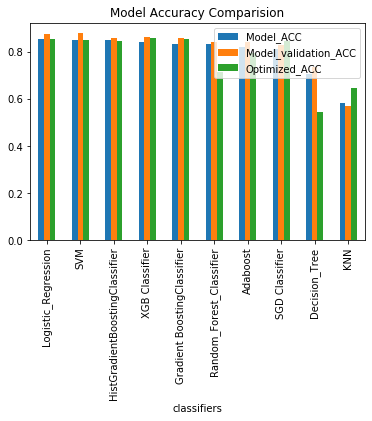

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, df["label"].tolist(), test_size=0.15)

DF_report,report=modelling(x_train,y_train,x_test,y_test)

# 5. Final Report

In [8]:

DF_report

,classifiers,Model_ACC,Model_validation_ACC,Optimized_ACC,Improvment
0,Logistic_Regression,0.854118,0.876667,0.852941,-0.001176
5,SVM,0.851765,0.880000,0.848235,-0.003529
8,HistGradientBoostingClassifier,0.848824,0.860000,0.847647,-0.001176
3,XGB Classifier,0.842941,0.863333,0.857647,0.014706
2,Gradient BoostingClassifier,0.833529,0.856667,0.854118,0.020588
4,Random_Forest_Classifier,0.833529,0.840000,0.715294,-0.118235
9,Adaboost,0.820588,0.840000,0.792941,-0.027647
1,SGD Classifier,0.811765,0.830000,0.845294,0.033529
7,Decision_Tree,0.705882,0.736667,0.544118,-0.161765
6,KNN,0.581176,0.570000,0.648235,0.067059


# 6. API Report:

In [14]:
report

{'Logistic_Regression': {'Original_model_Train_Acc': 0.8541176470588235,
  'Original_model_Test_Acc': 0.8766666666666667,
  'Original_model_CM': [array([[139,  20],
          [ 17, 124]], dtype=int64)],
  'Original_model_Report': ['              precision    recall  f1-score   support\n\n           1       0.89      0.87      0.88       159\n           2       0.86      0.88      0.87       141\n\n    accuracy                           0.88       300\n   macro avg       0.88      0.88      0.88       300\nweighted avg       0.88      0.88      0.88       300\n'],
  'Optimized_param': {'C': 0.03359818286283781,
   'penalty': 'l2',
   'solver': 'liblinear'},
  'Optimized_model_Train_Acc': 0.8529411764705882,
  'Optimized_model_Test_Acc': 0.87,
  'Optimized_model_CM': [array([[135,  24],
          [ 15, 126]], dtype=int64)],
  'Optimized_model_Report': ['              precision    recall  f1-score   support\n\n           1       0.90      0.85      0.87       159\n           2       0.84 